Shapiro-Wilk Test for 512 Batch Size - Main Thread Time (ms): p-value = 5.153459290859934e-14
-> Main Thread Time (ms) in Batch Size 512 is not normally distributed.

Shapiro-Wilk Test for 5120 Batch Size - Main Thread Time (ms): p-value = 1.6028121903788702e-13
-> Main Thread Time (ms) in Batch Size 5120 is not normally distributed.

Shapiro-Wilk Test for 512 Batch Size - Physics Time (ms): p-value = 1.0608425514877175e-11
-> Physics Time (ms) in Batch Size 512 is not normally distributed.

Shapiro-Wilk Test for 5120 Batch Size - Physics Time (ms): p-value = 7.796061311281218e-20
-> Physics Time (ms) in Batch Size 5120 is not normally distributed.

Shapiro-Wilk Test for 512 Batch Size - System Memory (MB): p-value = 2.548828552979597e-20
-> System Memory (MB) in Batch Size 512 is not normally distributed.

Shapiro-Wilk Test for 5120 Batch Size - System Memory (MB): p-value = 1.2361070352788641e-17
-> System Memory (MB) in Batch Size 5120 is not normally distributed.

Shapiro-Wilk Test

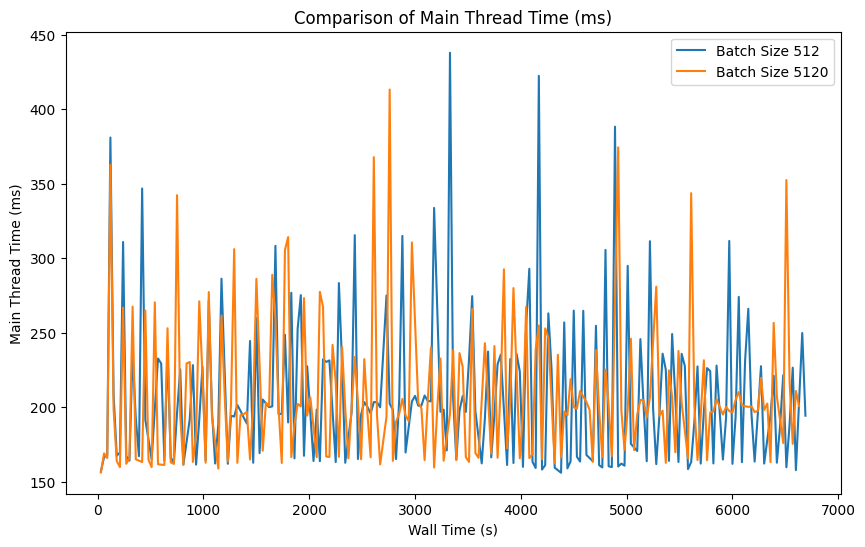

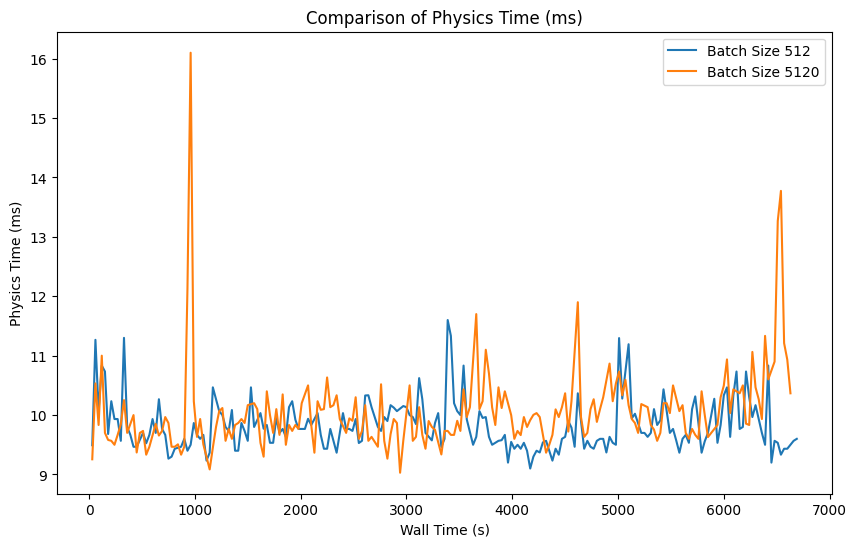

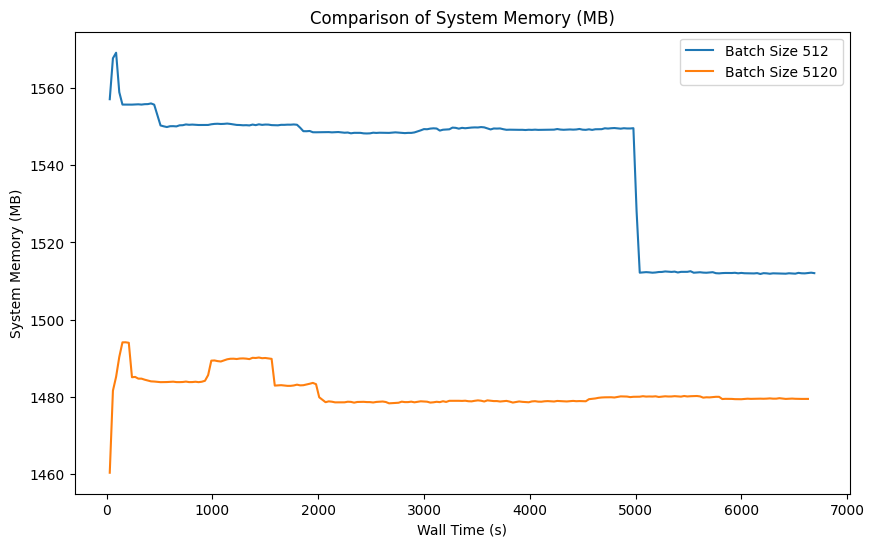

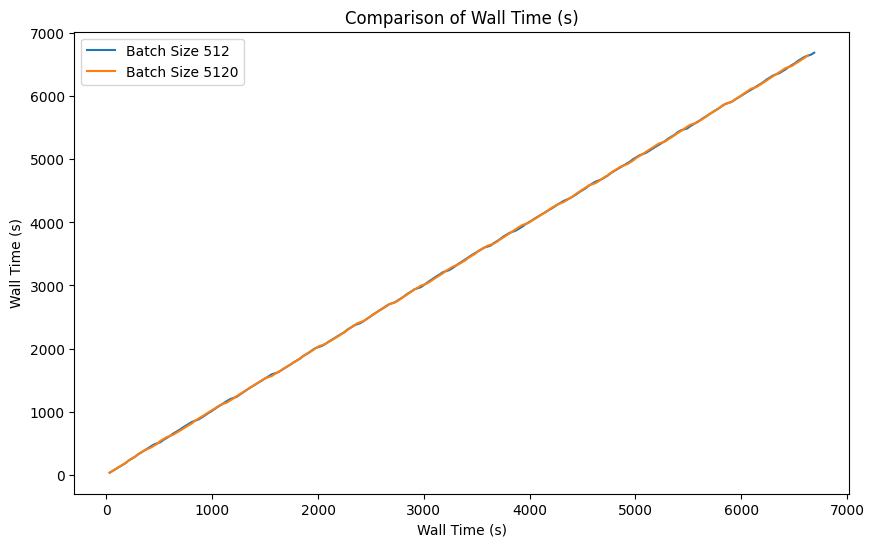

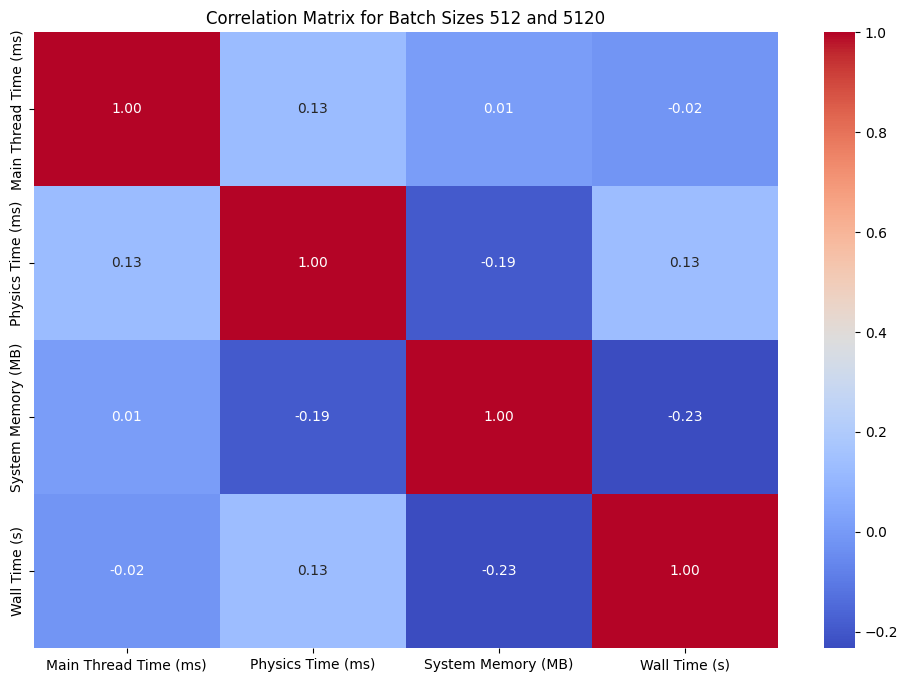

In [3]:
import pandas as pd
from scipy.stats import shapiro, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

# Define file paths
batch_size_512_files = [
    'Batch-size_512-1.csv',
    'Batch-size_512-2.csv',
    'Batch-size_512-3.csv'
]

batch_size_5120_files = [
    'Batch-size_5120-1.csv',
    'Batch-size_5120-2.csv',
    'Batch-size_5120-3.csv'
]

# Load and trim data
def load_trimmed_data(file_paths):
    dfs = [pd.read_csv(fp) for fp in file_paths]
    min_length = min(df.shape[0] for df in dfs)
    trimmed_dfs = [df.iloc[:min_length] for df in dfs]
    return trimmed_dfs

trimmed_512 = load_trimmed_data(batch_size_512_files)
trimmed_5120 = load_trimmed_data(batch_size_5120_files)

# Calculate the average using groupby with level=0
avg_512 = pd.concat(trimmed_512).groupby(level=0).mean().reset_index(drop=True)
avg_5120 = pd.concat(trimmed_5120).groupby(level=0).mean().reset_index(drop=True)

# Convert Wall Time from ms to seconds
avg_512['Wall Time (s)'] = avg_512['Wall Time (ms)'] / 1000
avg_5120['Wall Time (s)'] = avg_5120['Wall Time (ms)'] / 1000

# Create a new column for 30-second intervals
avg_512['Interval_30s'] = (avg_512['Wall Time (s)'] // 30) * 30
avg_5120['Interval_30s'] = (avg_5120['Wall Time (s)'] // 30) * 30

# Group by the 30-second intervals and calculate the mean
cleaned_avg_512 = avg_512.groupby('Interval_30s').mean().reset_index()
cleaned_avg_5120 = avg_5120.groupby('Interval_30s').mean().reset_index()

# Normality check using Shapiro-Wilk
factors = ['Main Thread Time (ms)', 'Physics Time (ms)', 'System Memory (MB)', 'Wall Time (s)']
for factor in factors:
    stat, p = shapiro(cleaned_avg_512[factor])
    print(f'Shapiro-Wilk Test for 512 Batch Size - {factor}: p-value = {p}')
    if p > 0.05:
        print(f'-> {factor} in Batch Size 512 is normally distributed.\n')
    else:
        print(f'-> {factor} in Batch Size 512 is not normally distributed.\n')
        
    stat, p = shapiro(cleaned_avg_5120[factor])
    print(f'Shapiro-Wilk Test for 5120 Batch Size - {factor}: p-value = {p}')
    if p > 0.05:
        print(f'-> {factor} in Batch Size 5120 is normally distributed.\n')
    else:
        print(f'-> {factor} in Batch Size 5120 is not normally distributed.\n')

# Mann-Whitney U Test
for factor in factors:
    stat, p = mannwhitneyu(cleaned_avg_512[factor], cleaned_avg_5120[factor])
    print(f'Mann-Whitney U Test for {factor}: p-value = {p}')
    if p < 0.05:
        print(f'-> The difference in {factor} between Batch Size 512 and 5120 is statistically significant.\n')
    else:
        print(f'-> The difference in {factor} between Batch Size 512 and 5120 is not statistically significant.\n')

# Line graphs for each factor
for factor in factors:
    plt.figure(figsize=(10, 6))
    plt.plot(cleaned_avg_512['Interval_30s'], cleaned_avg_512[factor], label='Batch Size 512')
    plt.plot(cleaned_avg_5120['Interval_30s'], cleaned_avg_5120[factor], label='Batch Size 5120')
    plt.title(f'Comparison of {factor}')
    plt.xlabel('Wall Time (s)')
    plt.ylabel(factor)
    plt.legend()
    plt.show()

# Correlation matrix for both groups
combined = pd.concat([cleaned_avg_512.assign(Batch_Size='512'), 
                      cleaned_avg_5120.assign(Batch_Size='5120')])
corr_matrix = combined[factors].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix for Batch Sizes 512 and 5120')
plt.show()